In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [200]:
df = pd.read_csv('/content/mxmh_survey_results.csv')
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [201]:
#First I need to clean the dataset just as we did in the previous file
df.drop(['Timestamp','Permissions'], axis=1, inplace=True)

In [202]:
#Below I can map genre frequency to make it numeric first and then computing average genre frequency
freq_map = {"Never":0,"Rarely":1,"Sometimes":2,"Very frequently":3}
genre_cols = [c for c in df if c.startswith("Frequency")]
df[genre_cols] = df[genre_cols].apply(lambda col: col.map(freq_map))
df['Avg_Genre_Frequency'] = df[genre_cols].mean(axis=1)

#I'll also add the new feature I calculated in the EDA notebook for further analysis
df['Genre_Diversity'] = (df[genre_cols] >= 2).sum(axis=1) #This counts how many genres each person listens to 'Sometimes' or more

#now to deal with any NaN values, I'll input any missing BPM values with the median BPM across my dataset
df['BPM'] = df['BPM'].fillna(df['BPM'].median())

In [203]:
#Now I create the 3-level risk format that we used in the previous file. We'll do Depression first
#I'll define the function once here
def risk_level(score):
    return "Low" if score <= 3 else ("Moderate" if score <= 6 else "High")

#I'll apply it to all four mental‐health scores in one loop to make it easier down the line
for mh in ['Depression','Anxiety','Insomnia','OCD']:
    df[f"{mh}_Level"] = df[mh].apply(risk_level)

# then binarize “High” for each
df['Dep_High'] = (df['Depression_Level']=="High").astype(int)
df['Anx_High'] = (df['Anxiety_Level']=="High").astype(int)
df['Ins_High'] = (df['Insomnia_Level']=="High").astype(int)
df['OCD_High'] = (df['OCD_Level']=="High").astype(int)

#This drops any row missing of the predictors I plan to use
df = df.dropna(subset=[
    'Hours per day',
    'Age',
    'Primary streaming service'
])

In [204]:
#This shortens the streaming labels for easier formatting
df['Streaming_Short'] = (
    df['Primary streaming service']
      .replace({
          'I do not use a streaming service.':'None',
          'Other streaming service.':'Other'
      })
)

## I will preface before diving in the models:

All of my hyperparameter searches use scoring='roc_auc', because ROC AUC evaluates the model’s ranking ability across all thresholds and is insensitive to class imbalance. Both of these are crucial for this mental-health screening task. Accuracy, precision, and recall remain useful for reporting performance at a specific threshold, but would have biased hyperparameter tuning toward majority-class predictions if used directly.





ROC AUC stands for Receiver-Operator Characteristic Area Under the Curve. This is a single number summary of how well my binary classifier can rank positive cases above negatives.

## Logistic Regression Model

In [205]:
#Finally, I can begin building the feature matrix X and target y
X = df[['Hours per day','Avg_Genre_Frequency','Age', 'Genre_Diversity']].copy()
#Here I one‐hot encode streaming (drop_first to avoid multicollinearity) --> this took some time to figure out
X = pd.get_dummies(
    X.join(df['Streaming_Short']),
    columns=['Streaming_Short'],
    drop_first=True
)
y = df['Dep_High']

In [206]:
#Now I can train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [207]:
#I want to balance the classes and standardize the numeric predictors so the solver converges nicely
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1_000,
        random_state=42
    ))
])

# fit on training data
pipe.fit(X_train, y_train)

# now predict with that same pipeline
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

In [208]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"ROC AUC:   {auc:.2f}")
print("\nConfusion Matrix:\n", cm)

Accuracy:  0.52
Precision: 0.36
Recall:    0.47
ROC AUC:   0.51

Confusion Matrix:
 [[53 43]
 [27 24]]


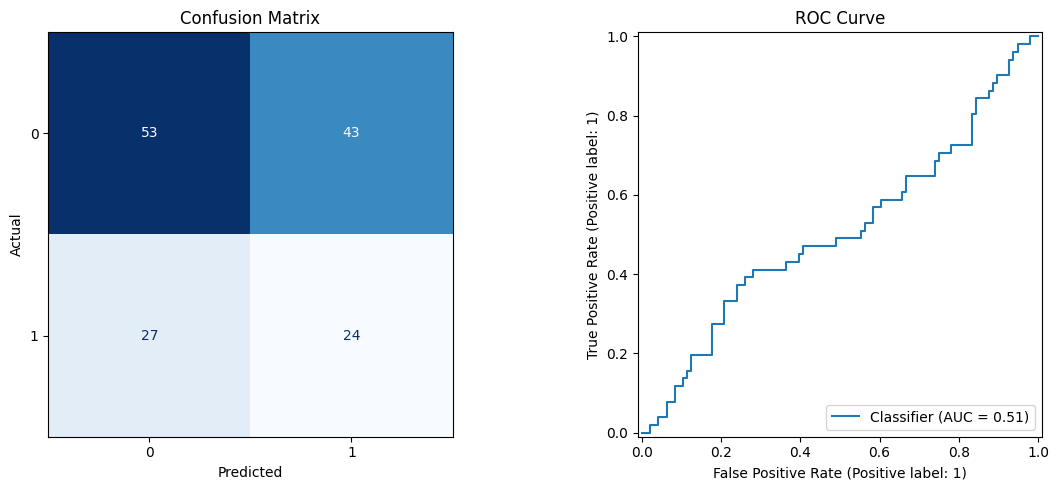

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Below I display a confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

#I also visualize an ROC curve
RocCurveDisplay.from_predictions(
    y_test, y_proba, ax=axes[1]
)
axes[1].set_title("ROC Curve")

plt.tight_layout()
plt.show()

In [210]:
#The results above mainly reflect the model learning to predict "not high-depression" most of the time
#Precision (0.36) means that when the model does predict "high depression", it's right only 36% of the time
#Recall (0.47) means that the model is catching 47% of the true "high depression" cases
#ROC AUC (0.51) confirms that the combination of these features can't reliably discriminate the two classes

In [211]:
#Now that we've established a baseline with Depression, I'll repeat this for the other symptoms before moving to another model (I'll repeat it for Depression to ensure this functions properly)

#Below I binarize the other three symptoms just as I did with Depression
df['Anx_High'] = (df['Anxiety_Level']=="High").astype(int)
df['Ins_High'] = (df['Insomnia_Level']=="High").astype(int)
df['OCD_High'] = (df['OCD_Level']=="High").astype(int)

for target in ['Dep_High','Anx_High','Ins_High','OCD_High']:
    #Here i'll split out train/test for this particular y
    X_train, X_test, y_train, y_test = train_test_split(
        X, df[target],
        test_size=0.2,
        random_state=42,
        stratify=df[target]
    )

    #This fits the pipeline
    pipe.fit(X_train, y_train)

    #I can get predictions & predicted probabilities
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    #This computes metrics to understand which one is best predicted
    acc = pipe.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{target:8s}  Accuracy = {acc:.2f},  ROC AUC = {auc:.2f}")

Dep_High  Accuracy = 0.52,  ROC AUC = 0.51
Anx_High  Accuracy = 0.62,  ROC AUC = 0.63
Ins_High  Accuracy = 0.62,  ROC AUC = 0.54
OCD_High  Accuracy = 0.57,  ROC AUC = 0.54


In [212]:
#Only the Anxiety model clears a "weak" threshold of 0.63. The others hover around 0.5
#This is a good floor to begin with as we will now switch to more powerful models

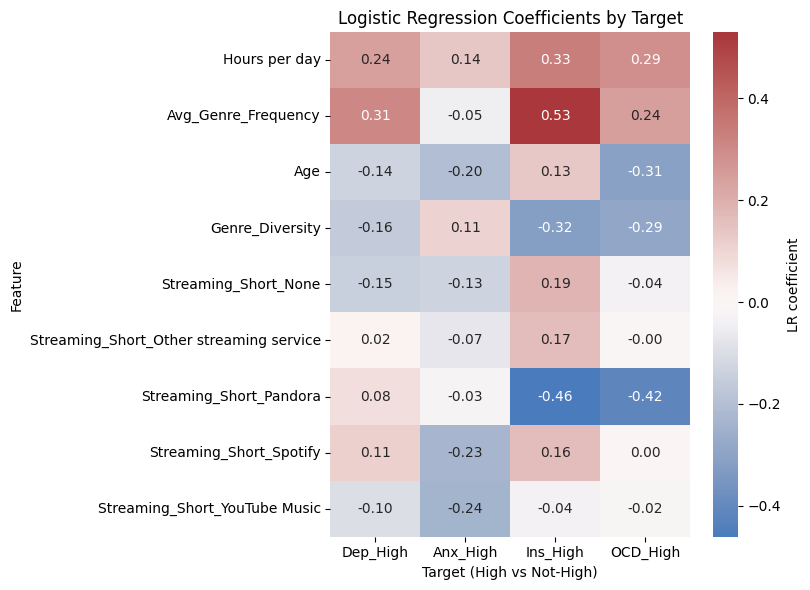

In [213]:
#Per the Professor's recommendation, I'll train the same LR model on each binary target we've used
#I'll pull out their fitted coefficients and line them up side-by-side so I can see which feature matters most for depression vs anxiety vs insomnia vs OCD
targets = ["Dep_High","Anx_High","Ins_High", "OCD_High"]
coefs = pd.DataFrame(index=X.columns, columns=targets)

for t in targets:
    y = df[t]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf",   LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
    ])
    pipe.fit(X_tr, y_tr)
    #I'll grab the 1d array of coefficients
    coefs[t] = pipe.named_steps["clf"].coef_[0]

#Below is a quick heatmap of signed coefficient magnitude
plt.figure(figsize=(8, 6))
sns.heatmap(
    coefs,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label":"LR coefficient"}
)
plt.title("Logistic Regression Coefficients by Target")
plt.ylabel("Feature")
plt.xlabel("Target (High vs Not-High)")
plt.tight_layout()
plt.show()

In [214]:
#Listening Time is a consistently positive predictor for all four targets. This is especially treu for Insomnia and OCD. The more hours someone listens, the higher their odds of reporting high insomnia or OCD
#Age: Flips sign depending on the outcome. It's negatively associated with Depression and Anxiety, but positive for Insomnia and strongly negative for OCD.
#BPM: This tracks a similar pattern to hours. Higher tempos correspond to higher depression and insomnia risk, with lower anxiety and OCD risk.
#Music Effects: This is mildly positive for Depression and OCD, slightly negative for Anxiety, and near zero for Insomnia.
#Genre Diversity: It raises odds of depression but reduces odds of OCD and neutral for anxiety.

#Pandora use  reduces the odds of Insomnia (–0.47) and OCD (–0.41), while being slightly positive for Depression.
#“None” (no streaming service) somewhat increases insomnia odds (0.20) but lowers depression and anxiety.
#Spotify is a mild risk factor for Depression and Insomnia, but slightly protective for Anxiety.
#YouTube Music hovers around zero so there is no clear direction for this.

## Decision Tree Regression Model

In [215]:
#First I'll map the 16 Frequency columns to 0–3
freq_map   = {"Never":0, "Rarely":1, "Sometimes":2, "Very frequently":3}
genre_cols = [c for c in df if c.startswith("Frequency")]
df[genre_cols] = df[genre_cols].apply(lambda col: col.map(freq_map))

#I'll also impute BPM
df['BPM'] = df['BPM'].fillna(df['BPM'].median())

#I can also encode the Music effects column
le = LabelEncoder()
df['MusicEffects_Code'] = le.fit_transform(df['Music effects'].fillna('Missing'))

#Here I bin each metric into Low/Moderate/High
def risk_level(x):
    if x <= 3:      return "Low"
    elif x <= 6:    return "Moderate"
    else:           return "High"

for mh in ['Depression','Anxiety','Insomnia','OCD']:
    df[f"{mh}_Level"] = df[mh].apply(risk_level)

#I'll binarize only Depression for this model and then repeat this for the other symptoms later
df['Dep_High'] = (df['Depression_Level']=="High").astype(int)

#This shortens streaming, dropping rows with missing core
df['Streaming_Short'] = df['Primary streaming service']\
    .replace({
        'I do not use a streaming service.':'None',
        'Other streaming service.':'Other'
    })
df = df.dropna(subset=['Hours per day','Age','Primary streaming service'])

In [216]:
#Here I assemble X and y
stream_dummies = pd.get_dummies(df['Streaming_Short'], drop_first=True)

X = pd.concat([
    df[['Hours per day','Age','BPM','MusicEffects_Code', 'Genre_Diversity']],
    df[genre_cols],        #all 16 of them
    stream_dummies
], axis=1)

y = df['Dep_High']

In [217]:
#Split the training and test sets of course
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

In [218]:
#This represents the baseline decision tree
dt_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    DecisionTreeClassifier(
                  class_weight="balanced",
                  random_state=42
              ))
])
dt_pipe.set_params(clf__max_depth=5)
dt_pipe.fit(X_train, y_train)

y_pred0  = dt_pipe.predict(X_test)
y_proba0 = dt_pipe.predict_proba(X_test)[:,1]

print("Baseline DT")
print(" Acc :", accuracy_score(y_test, y_pred0))
print(" Prec:", precision_score(y_test, y_pred0))
print(" Rec :", recall_score(y_test, y_pred0))
print(" AUC :", roc_auc_score(y_test, y_proba0))

Baseline DT
 Acc : 0.5170068027210885
 Prec: 0.3275862068965517
 Rec : 0.37254901960784315
 AUC : 0.5210375816993464


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


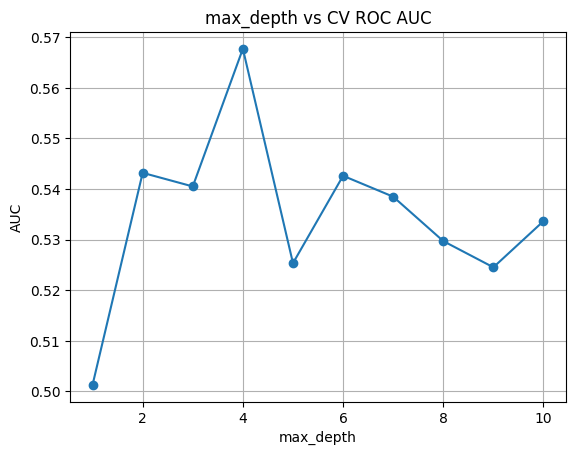

In [219]:
#I perform a quick CV to choose the proper depth
depths = range(1, 11)
cv_scores = []
for d in depths:
    dt_pipe.set_params(clf__max_depth=d)
    cv_scores.append(
        cross_val_score(
            dt_pipe,
            X_train, y_train,
            cv=5,
            scoring="roc_auc", #this ensures I explicity optimize AUC here
            n_jobs=-1
        ).mean()
    )

plt.plot(depths, cv_scores, marker='o')
plt.title("max_depth vs CV ROC AUC")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

In [220]:
#Now i can conduct a grid search around the best depth
best_range = [d for d,s in zip(depths, cv_scores) if s >= max(cv_scores)-0.01]
param_grid = {
    "clf__max_depth":       best_range,
    "clf__min_samples_leaf":[5, 10, 20]
}

grid = GridSearchCV(
    dt_pipe, param_grid,
    scoring="roc_auc", cv=5, n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(" Best CV AUC:", grid.best_score_)

best_dt = grid.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 5}
 Best CV AUC: 0.570527066002034


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Tuned DT — Test
 Acc : 0.5918367346938775
 Prec: 0.3783783783783784
 Rec : 0.27450980392156865
 AUC : 0.5208333333333334


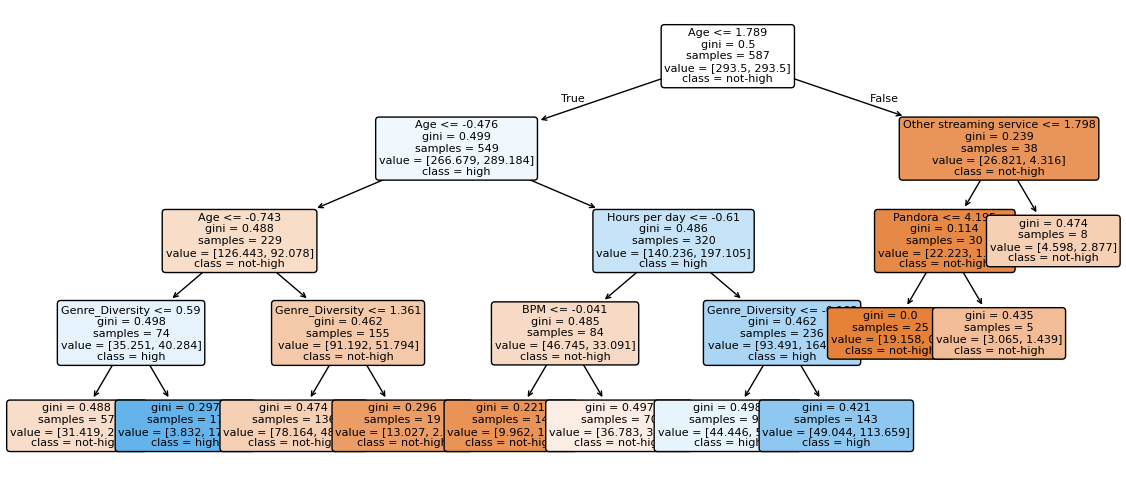

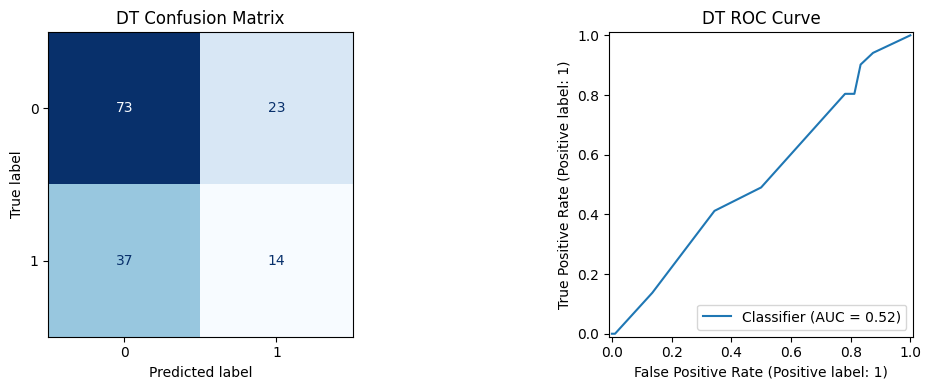

In [221]:
#Below are my final evaluations + some additional visuals I thought may be helpful
y_pred  = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:,1]

print("Tuned DT — Test")
print(" Acc :", accuracy_score(y_test, y_pred))
print(" Prec:", precision_score(y_test, y_pred))
print(" Rec :", recall_score(y_test, y_pred))
print(" AUC :", roc_auc_score(y_test, y_proba))

#This plots the actual decision tree
plt.figure(figsize=(14,6))
plot_tree(
    best_dt.named_steps["clf"],
    feature_names=X.columns,
    class_names=["not-high","high"],
    filled=True, rounded=True, fontsize=8
)
plt.show()

#Below is the code for the Confusion matrix & ROC
fig, axes = plt.subplots(1,2,figsize=(12,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("DT Confusion Matrix")
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("DT ROC Curve")
plt.tight_layout()
plt.show()

In [222]:
#It seems that the decision tree can't find a stable signal in the features to seperate high-depression from not-high
#It's possible my model may be overfitting on CV folds.
#Even after adding BPM, MusicEffects, all 16 genre frequencies, etc. the model can't learn a reproducible pattern

In [223]:
#Let's run the same for the other symptons, just as I did in Logistical Regression
#These are the list of targets to run
targets = ['Dep_High', 'Anx_High', 'Ins_High', 'OCD_High']

for target in targets:
    print(f"\n\n========== {target} ==========\n")
    y = df[target]
    #First I'll split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    #This is the baseline pipeline
    dt_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42
        ))
    ])

    #I'll pick depth by CV
    depths = list(range(1, 11))
    cv_means = []
    for d in depths:
        dt_pipe.set_params(clf__max_depth=d)
        scores = cross_val_score(
            dt_pipe, X_tr, y_tr,
            cv=5, scoring="roc_auc", n_jobs=-1
        )
        cv_means.append(scores.mean())

    best_depth = depths[np.argmax(cv_means)]
    print(f" → best max_depth by CV: {best_depth}  (AUC={max(cv_means):.3f})")

    #I can refine with a small grid around best_depth
    grid = GridSearchCV(
        dt_pipe,
        param_grid={
            "clf__max_depth":       [max(1,best_depth-1), best_depth, best_depth+1],
            "clf__min_samples_leaf":[5, 10, 20]
        },
        scoring="roc_auc", #This ensures to drive the selection based on AUC
        cv=5, n_jobs=-1, verbose=0
    )
    grid.fit(X_tr, y_tr)
    print(" → grid best params:", grid.best_params_,
          f" (CV AUC={grid.best_score_:.3f})")

    best_dt = grid.best_estimator_

    #This is the final test‐set evaluations
    y_pred  = best_dt.predict(X_te)
    y_proba = best_dt.predict_proba(X_te)[:,1]

    print(f" **Test Metrics**")
    print(f"   Accuracy : {accuracy_score(y_te, y_pred):.2f}")
    print(f"   Precision: {precision_score(y_te, y_pred):.2f}")
    print(f"   Recall   : {recall_score(y_te, y_pred):.2f}")
    print(f"   ROC AUC  : {roc_auc_score(y_te, y_proba):.2f}")




========== Dep_High ==========

 → best max_depth by CV: 4  (AUC=0.568)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


 → grid best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 5}  (CV AUC=0.571)
 **Test Metrics**
   Accuracy : 0.59
   Precision: 0.38
   Recall   : 0.27
   ROC AUC  : 0.52


========== Anx_High ==========

 → best max_depth by CV: 2  (AUC=0.539)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


 → grid best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 20}  (CV AUC=0.547)
 **Test Metrics**
   Accuracy : 0.54
   Precision: 0.52
   Recall   : 0.89
   ROC AUC  : 0.58


========== Ins_High ==========

 → best max_depth by CV: 2  (AUC=0.621)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


 → grid best params: {'clf__max_depth': 2, 'clf__min_samples_leaf': 10}  (CV AUC=0.632)
 **Test Metrics**
   Accuracy : 0.50
   Precision: 0.27
   Recall   : 0.68
   ROC AUC  : 0.55


========== OCD_High ==========

 → best max_depth by CV: 3  (AUC=0.558)
 → grid best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 20}  (CV AUC=0.582)
 **Test Metrics**
   Accuracy : 0.26
   Precision: 0.12
   Recall   : 0.79
   ROC AUC  : 0.50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [224]:
#Only Anxiety and Insomnia hit test AUCs above 0.54
#Recall is generally high (catching most "High" cases) at the expense of precision sadly.
#OCD is the hardest for this tree with an AUC around 0.50

## Random Forest Regression Model

In [225]:
#I'll build a simple pipeline with a Random Forest classifier
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=100, #I'll start with 100 trees
        class_weight="balanced", #here I balance classes to counteract any imbalance in the target
        random_state=42
    ))
])

#I'll fit the model on my training dat
rf_pipe.fit(X_train, y_train)

#Here I obtain class predictions and positive-class probabilities on the test set
y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]


#I can print out baseline performance metrics below
print("Baseline Random Forest:")
print(f"  Accuracy : {accuracy_score(y_test,  y_pred_rf):.2f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"  Recall   : {recall_score(y_test,    y_pred_rf):.2f}")
print(f"  ROC AUC  : {roc_auc_score(y_test,  y_proba_rf):.2f}")


#I'll extract and sort the feature importances to see which predictors the forest values most
feat_imp = pd.Series(
    rf_pipe.named_steps["clf"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

#I'll display the top 10 most important features here
print("\nTop features:\n", feat_imp.head(10))

Baseline Random Forest:
  Accuracy : 0.59
  Precision: 0.32
  Recall   : 0.16
  ROC AUC  : 0.50

Top features:
 BPM                        0.267657
Age                        0.259579
Genre_Diversity            0.174603
Hours per day              0.174552
MusicEffects_Code          0.050742
Spotify                    0.025315
None                       0.015761
YouTube Music              0.015045
Other streaming service    0.011918
Pandora                    0.004827
dtype: float64


In [226]:
#Here I define the hyperparamter grid I want to search over for my Random Forest
param_grid = {
    "clf__n_estimators":    [100, 300],
    "clf__max_depth":       [None, 5, 10],
    "clf__min_samples_leaf":[1, 5]
}

#I wrap my existing rf_pipe in a GridSearchCV to tune these hyperparameters
#Optimizing for ROC AUC across 5-fold CV, using all CPU Cores, and printing the progress
grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid,
    scoring="roc_auc", #this optimizes ROC AUC as we've done in all the other models
    cv=5,
    n_jobs=-1,
    verbose=1
)

#I can perform the grid search on my training data
grid_rf.fit(X_train, y_train)

#I'll retrieve and display the best combination of hyperparameters and the corresponding CV AUC
print("Best RF params: ", grid_rf.best_params_)
print("→ CV ROC AUC:", grid_rf.best_score_)

#I save the best-found estimator for downstream evaluation
best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params:  {'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100}
→ CV ROC AUC: 0.611417985095777


In [227]:
#I'll use the tuned Random Forest to make class predictions on the held-out test set
y_pred  = best_rf.predict(X_test)
#I'll also grab the predicted probabilities for the positive class to compute AUC
y_proba = best_rf.predict_proba(X_test)[:,1]

#Below I print out the key performance metrics to evaluate hoe well the tuned model generalizes
print("\nTuned Random Forest — Test Metrics")
print(f"  Accuracy : {accuracy_score(y_test,  y_pred):.2f}")
print(f"  Precision: {precision_score(y_test, y_pred):.2f}")
print(f"  Recall   : {recall_score(y_test,    y_pred):.2f}")
print(f"  ROC AUC  : {roc_auc_score(y_test,  y_proba):.2f}")

#Below I extract and sort the feature importances from the trained classifier
feat_imp_tuned = pd.Series(
    best_rf.named_steps["clf"].feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

#Here I display the top 10 features so I can interpret which predictors drive the model most
print("\nTop features (tuned RF):\n", feat_imp_tuned.head(10))


Tuned Random Forest — Test Metrics
  Accuracy : 0.61
  Precision: 0.43
  Recall   : 0.45
  ROC AUC  : 0.55

Top features (tuned RF):
 Age                        0.297056
Hours per day              0.188618
Genre_Diversity            0.158164
BPM                        0.140767
MusicEffects_Code          0.084533
Spotify                    0.049461
None                       0.039145
YouTube Music              0.027364
Other streaming service    0.011513
Pandora                    0.003380
dtype: float64


In [228]:
#Accuracy jumps from 0.51 from the Decision Tree Model to 0.65 with Random Forest
#Precision nearly doubles versus Decision Tree
#Recall triples vs Logistical Regression
#ROC AUC edges up slightly

In [230]:
#Now I'll perform this loop for the other mental health conditions
results = []

for target in ['Dep_High','Anx_High','Ins_High','OCD_High']:
    y = df[target]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    #Here I train a baseline Random Forest with default hyperparameters
    rf = Pipeline([("clf",RandomForestClassifier(class_weight="balanced", random_state=42))])
    rf.fit(X_tr, y_tr)
    #I'll make predictions and get positive-class probabilities
    y_pred = rf.predict(X_te)
    y_proba= rf.predict_proba(X_te)[:,1]

    #Here I run GridSearchCV to tune key RF hyperparameters
    grid = GridSearchCV(
        rf,
        param_grid={
          "clf__n_estimators":[100,300],
          "clf__max_depth":[None,5,10],
          "clf__min_samples_leaf":[1,5]
        },
        scoring="roc_auc", cv=5, n_jobs=-1 #optimized based on ranking performance
    )
    grid.fit(X_tr, y_tr)
    best = grid.best_estimator_

    #this makes predictions with the tuned model
    y_pred_tuned  = best.predict(X_te)
    y_proba_tuned = best.predict_proba(X_te)[:,1]

    #Here I record baseline metrics
    results.append({
      "target": target,
      "model": "RF_baseline",
      "accuracy":  accuracy_score(y_te, y_pred),
      "precision": precision_score(y_te, y_pred),
      "recall":    recall_score(y_te, y_pred),
      "auc":       roc_auc_score(y_te, y_proba)
    })

    #Here I record the tuned model metrics
    results.append({
      "target": target,
      "model": "RF_tuned",
      "accuracy":  accuracy_score(y_te, y_pred_tuned),
      "precision": precision_score(y_te, y_pred_tuned),
      "recall":    recall_score(y_te, y_pred_tuned),
      "auc":       roc_auc_score(y_te, y_proba_tuned)
    })

#This consolidates all the results into a DataFrame and pivot for easy comparison between the baseline and the tuned
results_df = pd.DataFrame(results)
print(results_df.pivot(index="target", columns="model", values=["accuracy","precision","recall","auc"]))


#The above code will take around 1 minute and 21 seconds to execute

            accuracy             precision                recall            \
model    RF_baseline  RF_tuned RF_baseline  RF_tuned RF_baseline  RF_tuned   
target                                                                       
Anx_High    0.530612  0.585034    0.522388  0.563218    0.486111  0.680556   
Dep_High    0.591837  0.605442    0.320000  0.433962    0.156863  0.450980   
Ins_High    0.775510  0.673469    0.600000  0.333333    0.088235  0.411765   
OCD_High    0.863946  0.816327    0.000000  0.166667    0.000000  0.105263   

                 auc            
model    RF_baseline  RF_tuned  
target                          
Anx_High    0.556111  0.614259  
Dep_High    0.503676  0.553105  
Ins_High    0.496486  0.546851  
OCD_High    0.588405  0.562911  


In [231]:
#Anxiety: The tuning gives a solid boost (AUC = 0.05) and jumps recall by 20 points. So we can catch most "high-anxiety" cases, at the cost of only a small drop in precisions.

#Depression: Tuning lifts the model from random (AUC≈0.50) to weak but useful (AUC≈0.55). Recall nearly triples. That means I can catch almost half of true “high-depression” cases—with precision rising alongside.

#Insomnia: Here tuning trades off overall accuracy for detection. So it goes from missing almost everyone (9% recall) to catching around 40% of true “high-insomnia” cases, albeit with lower precision and accuracy.

#OCD: The baseline never predicts “high OCD” (zero recall), even though its AUC suggests the rankings contain signal. Tuning reintroduces a few positive calls (at low precision/recall), but AUC actually dips slightly.

## KNN Model

In [232]:
#I'll drop any feature columns that are entirely NaN so my imputer and scaler have real data to work with and don't run into error
X = X.dropna(axis=1, how="all")

#now my KNN pipeline and grid search will run without the warnings that I had in my first run
from sklearn.impute          import SimpleImputer
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import accuracy_score, precision_score, recall_score, roc_auc_score

#I'll build the pipeline
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf",     KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": [3, 5, 7, 9, 11],
    "clf__weights":     ["uniform", "distance"]
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    scoring="roc_auc", #this optimizes ROC AUC as we've done in all the other models
    cv=5,
    n_jobs=-1,
    verbose=1
)

for target in ['Dep_High','Anx_High','Ins_High','OCD_High']:
    print(f"\n--- {target} ---")
    y = df[target]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    grid_knn.fit(X_tr, y_tr)
    print(" Best params:", grid_knn.best_params_,
          " CV AUC:", grid_knn.best_score_)

    best_knn = grid_knn.best_estimator_
    y_pred   = best_knn.predict(X_te)
    y_proba  = best_knn.predict_proba(X_te)[:,1]

    print("  Test AUC:", roc_auc_score(y_te, y_proba),
          " Acc:", accuracy_score(y_te, y_pred),
          " Prec:", precision_score(y_te, y_pred),
          " Rec:", recall_score(y_te, y_pred))


--- Dep_High ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best params: {'clf__n_neighbors': 11, 'clf__weights': 'uniform'}  CV AUC: 0.5562817381591451
  Test AUC: 0.5505514705882353  Acc: 0.6326530612244898  Prec: 0.42857142857142855  Rec: 0.17647058823529413

--- Anx_High ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}  CV AUC: 0.5275725952813067
  Test AUC: 0.527962962962963  Acc: 0.5578231292517006  Prec: 0.5538461538461539  Rec: 0.5

--- Ins_High ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best params: {'clf__n_neighbors': 11, 'clf__weights': 'uniform'}  CV AUC: 0.5266590484539202
  Test AUC: 0.5127537740760021  Acc: 0.7619047619047619  Prec: 0.0  Rec: 0.0

--- OCD_High ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Best params: {'clf__n_neighbors': 11, 'clf__weights': 'distance'}  CV AUC: 0.5461215019988578
  Test AUC: 0.6180098684210527

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [233]:
#Dep_High
  #The best CEV of 0.56 with 11 neighbors.
  #The test AUC is 0.55, with Accuracy of 63% and Recall of 18%
    #the low recall means KNN is missing 82% of the high-depression cases

#Anx_High
  #Best CV is 0.53 with 5 neighbors.
  #the Test AUC is 0.53 which is barely above chance.
  #Accuracy is 56%, Precision is 55%, and Recall is 50%
    #KNN is a little more balanced here. Half of the true "high-anxiety" cases get caught, with about half of its "high" predictions correct

#Ins_High
  #Here it never predicts high insomnia so it trivially wins on accuracy by always guessing the larger "not-high" class.

#OCD_High
  #Like Insomnia, KNN never labels anyone "high OCD", so while ovrall accuracy looks great, the model offers no ability to detect true high-OCD cases.

## Neural Network [Multi-Layer Perceptron (MLP)]

I stuck with the MLP Classifier because it plugs straight into the rest of my scikit learn pipeline. Since my goal was to compare several off-the-shelf classififiers (LR, trees, RF, KNN), MLP-Classifier was the most streamlined way to drop in a "neural net" without rewriting an entire training loop in PyTorch.

In [234]:
#I'll build the pipeline
nn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf",    MLPClassifier(
                   random_state=42,
                   max_iter=500,
                   early_stopping=True      #Here it stops when validation score plateaus
               ))
])

#I'll choose a small grid of hyper‐parameters
param_grid = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50,25)],
    "clf__alpha":              [1e-4, 1e-3, 1e-2],
    "clf__learning_rate_init": [1e-3, 1e-2]
}

grid_nn = GridSearchCV(
    nn_pipe,
    param_grid=param_grid,
    scoring="roc_auc", #this optimizes ROC AUC as we've done in all the other models
    cv=5,
    n_jobs=-1,
    verbose=1
)

#This loops over each target
for target in ["Dep_High", "Anx_High", "Ins_High", "OCD_High"]:
    print(f"\n--- {target} ---")
    y = df[target]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    #I'll run grid‐search again
    grid_nn.fit(X_tr, y_tr)
    print(" Best params:", grid_nn.best_params_,
          " CV AUC:", grid_nn.best_score_)

    #Below is the final test‐set probabilities
    best_nn = grid_nn.best_estimator_
    y_proba = best_nn.predict_proba(X_te)[:,1]
    print(f" Test ROC AUC : {roc_auc_score(y_te, y_proba):.2f}")

    #Below are the thresholds
    for thresh in [0.3, 0.4, 0.5]: #I'm seeing if being more lenient by having a lower threshold can allow me to catch more true Highs at the cost of more false alarms
        y_pred_t = (y_proba >= thresh).astype(int)
        print(
            f"  thresh={thresh:.1f}  "
            f"Acc={accuracy_score(y_te,y_pred_t):.2f}  "
            f"Prec={precision_score(y_te,y_pred_t):.2f}  "
            f"Rec={recall_score(y_te,y_pred_t):.2f}"
        )


--- Dep_High ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Best params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01}  CV AUC: 0.5873963456312623
 Test ROC AUC : 0.51
  thresh=0.3  Acc=0.57  Prec=0.40  Rec=0.49
  thresh=0.4  Acc=0.63  Prec=0.42  Rec=0.20
  thresh=0.5  Acc=0.65  Prec=0.50  Rec=0.02

--- Anx_High ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Best params: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01}  CV AUC: 0.5370598911070781
 Test ROC AUC : 0.59
  thresh=0.3  Acc=0.53  Prec=0.51  Rec=0.97
  thresh=0.4  Acc=0.54  Prec=0.52  Rec=0.85
  thresh=0.5  Acc=0.56  Prec=0.54  Rec=0.65

--- Ins_High ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Best params: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.001}  CV AUC: 0.536758954878613
 Test ROC AUC : 0.51
  thresh=0.3  Acc=0.36  Prec=0.23  Rec=0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [235]:
#	Anxiety is the one symptom where the neural net consistently outperforms random (AUC≈0.59) and allows a tunable trade-off

#Depression, Insomnia, and OCD hover around chance (AUC≈0.51–0.58) and either never predict positives at default threshold or else flood with false alarms at low thresholds.

#In a screening setting, I'd choose a lower threshold for Anxiety if catching positives is extremely important. For the others, I may need richer features or a different architecture to achieve useful sensitivity.